# Data Forecasting with prophet


# PROPHET PREDICTION

## TESTO

## Import Dependencies

In [1]:
!pip3 install chart_studio
!pip3 install fbprophet

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

### Read Dataset

In [4]:
dataset = pd.read_csv("/Users/riccardobaratin/Documents/GitHub/iot-project/datasets/temperature_dataset.csv",
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates
dataset.head()
#for t in df['_time'].values:
#     d=dateutil.parser.parse(t)
#     aux=d.strftime('%Y-%m-%d')
#     df['_time'].replace({t:aux },inplace=True)

,Temperature
Time,
2021-01-01 00:00:00,4.3
2021-01-01 01:00:00,4.1
2021-01-01 02:00:00,4.0
2021-01-01 03:00:00,3.8
2021-01-01 04:00:00,3.5


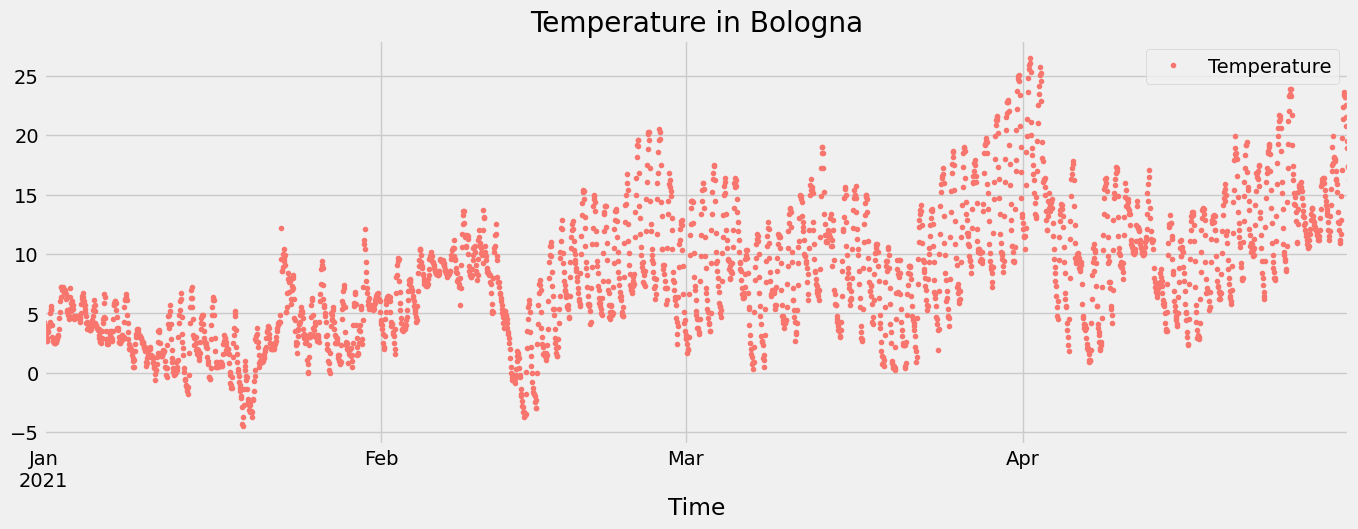

In [5]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
dataset.plot(style='.', figsize=(15,5), color=color_pal[0], title='Temperature in Bologna')
plt.show()

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(dataset, label='Temperature')

features_and_target = pd.concat([X, y], axis=1)

### Splitting Dataset Into Train Set And Test Set
#### Train set range from January 2021 to April 2021 ( four months). 
##### Test set covers one months of data points ( April – May )

In [8]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Temperature
Time,,,,,,,,,
2021-01-01 00:00:00,0,4,1,1,2021,1,1,53,4.3
2021-01-01 01:00:00,1,4,1,1,2021,1,1,53,4.1
2021-01-01 02:00:00,2,4,1,1,2021,1,1,53,4.0
2021-01-01 03:00:00,3,4,1,1,2021,1,1,53,3.8
2021-01-01 04:00:00,4,4,1,1,2021,1,1,53,3.5


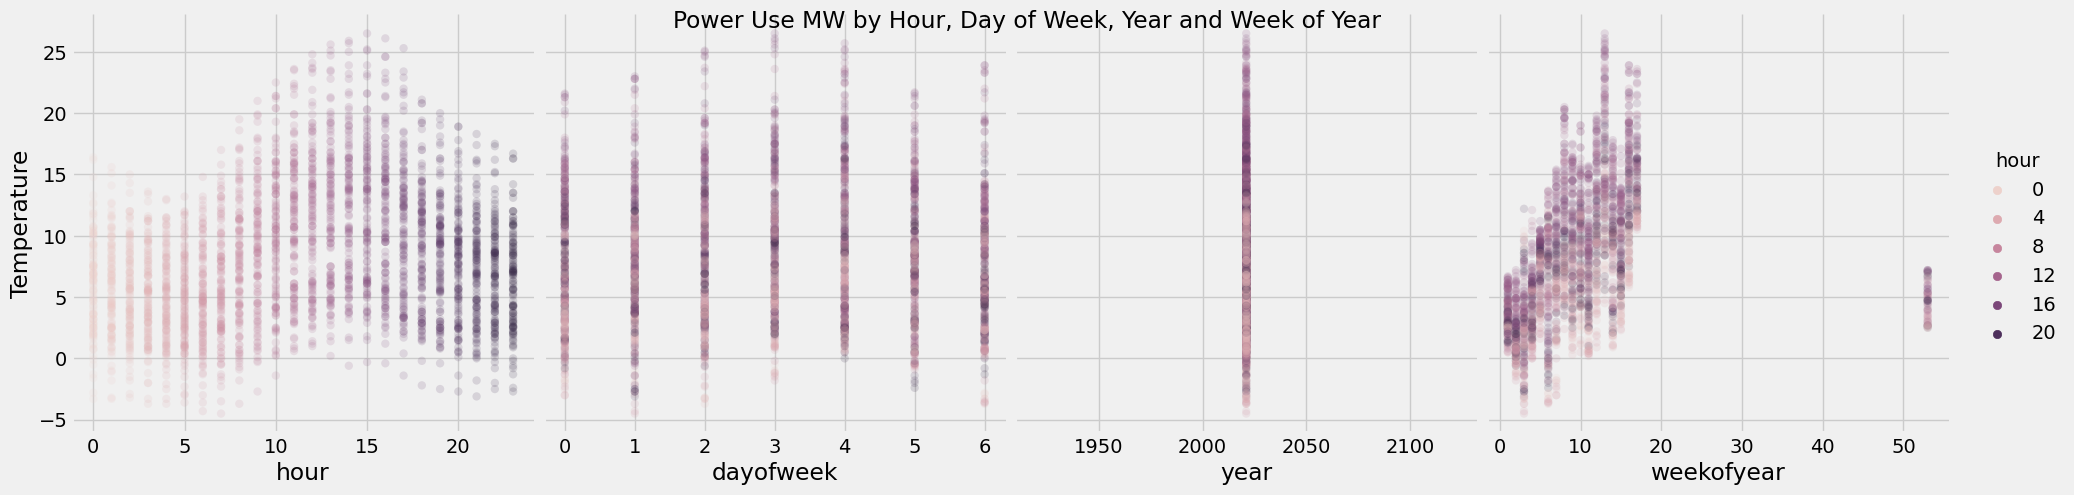

In [9]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='Temperature',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

### TRAINING FORECASTING MODEL USING PROPHET

Parameters in Prophet can be chosen based on the dataset and the patterns available in it. Tweaking these parameters will help us train our model for better results.

The data consists of a non-linear trend and a rise at the beginning and end of the month. Also a fall in the mid-months (July , August , September).

Having these analysis, we can proceed in building our Prophet Model.

growth = ‘logistic’ , 
seasonality_mode = ‘multiplicative’ 
daily_seasonality = True
Custom seasonality 

We can specify the additional seasonality components with the required period and fourier order. 

add_seasonality(name = ‘quarterly, period = 90.5, fourier_order = 48) 
add_seasonality(name = ‘yearly’, period = 365, fourier_order = 48)
Since the growth parameter to logistic, we have to specify the maximum capacity ‘cap‘ and minimum capacity ‘floor‘. Two columns named ‘cap’ and ‘floor’ assigned to the 

training set before fitting the model 
future set before forecasting

In [10]:
split_dataset = '2021-04-01'
dataset_train = dataset.loc[dataset.index <= split_dataset].copy()
dataset_test = dataset.loc[dataset.index > split_dataset].copy()

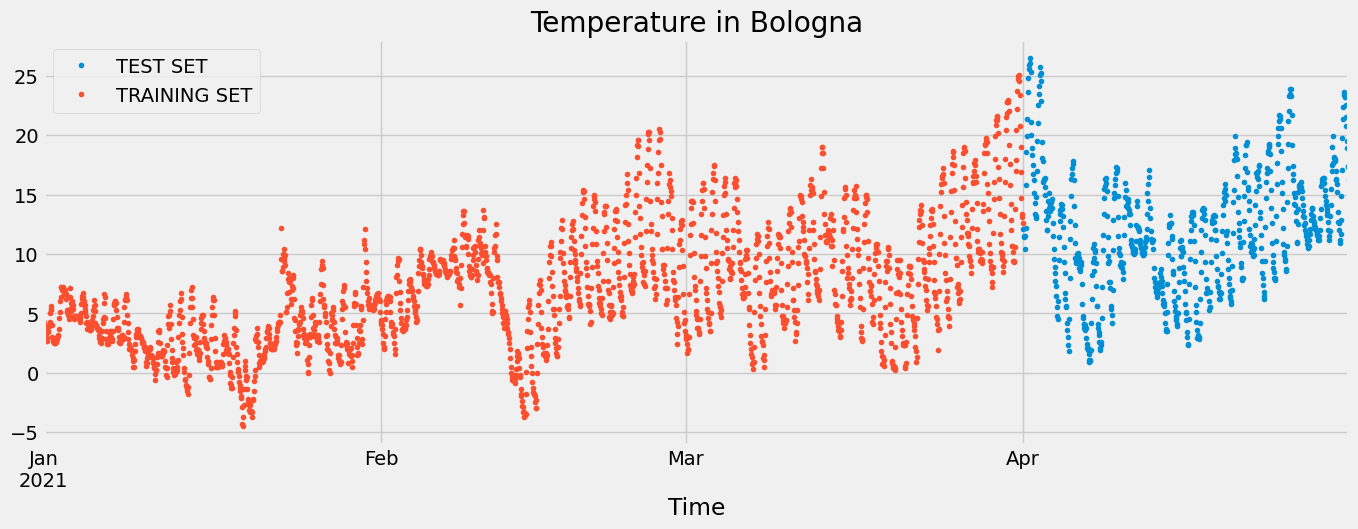

In [11]:
# Plot train and test so you can see where we have split
dataset_test \
    .rename(columns={'Temperature': 'TEST SET'}) \
    .join(dataset_train.rename(columns={'Temperature': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Temperature in Bologna', style='.')
plt.show()

### DEFINING FUTURE SET

Future set is what we want our model to forecast with the trained Prophet model. One year time period , the test set (January 1990 – December 1990) is taken as a future set.

In [12]:
# Format data for prophet model using ds and y
dataset_train.reset_index() \
    .rename(columns={'Time':'ds',
                     'Temperature':'y'}).head()

,ds,y
0,2021-01-01 00:00:00,4.3
1,2021-01-01 01:00:00,4.1
2,2021-01-01 02:00:00,4.0
3,2021-01-01 03:00:00,3.8
4,2021-01-01 04:00:00,3.5


In [13]:
# Setup and train model and fit
model = Prophet()
model.fit(dataset_train.reset_index() \
              .rename(columns={'Time':'ds',
                               'Temperature':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -34.394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       3482.73    0.00142897       141.595   1.627e-05       0.001      166  LS failed, Hessian reset 
      99       3482.75     0.0012841       115.874           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       3490.86   0.000428991       90.0059   2.073e-06       0.001      328  LS failed, Hessian reset 
     199       3491.52   0.000635097       70.9736           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3493.28     0.0177378        100.78           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       3497.58    0.00099704       251.127   4.637e-06       0.001      560  LS failed, Hessian reset

### FORECASTING THE FUTURE
Forecasting on the specified future dataframe can be done using the ‘predict’ function. This will make the forecasts with period and frequency mentioned. 

Forecasting using Prophet will provide a wide range of results with upper limit and lower limit as end result. ‘yhat’ column consists of the predicted value.

In [14]:
# Predict on training set with model
print(model.predict(df=dataset_test.reset_index() \
                                   .rename(columns={'Temperature':'ds'})))


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


                               ds        trend   yhat_lower   yhat_upper  \
0   1970-01-01 00:00:00.000000000  3715.787745  3710.872264  3718.193489   
1   1970-01-01 00:00:00.000000001  3715.787745  3710.944827  3718.134350   
2   1970-01-01 00:00:00.000000001  3715.787745  3710.553714  3718.221290   
3   1970-01-01 00:00:00.000000001  3715.787745  3710.788323  3718.075830   
4   1970-01-01 00:00:00.000000001  3715.787745  3710.816547  3717.959234   
..                            ...          ...          ...          ...   
714 1970-01-01 00:00:00.000000025  3715.787745  3710.852848  3718.053934   
715 1970-01-01 00:00:00.000000025  3715.787745  3710.964818  3717.858927   
716 1970-01-01 00:00:00.000000025  3715.787745  3711.013688  3717.933752   
717 1970-01-01 00:00:00.000000026  3715.787745  3711.036134  3717.807653   
718 1970-01-01 00:00:00.000000026  3715.787745  3710.748205  3718.050832   

     trend_lower  trend_upper  additive_terms  additive_terms_lower  \
0    3715.787745

In [263]:
train_model.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01 00:00:00.000000000,3715.787745,3710.511062,3718.342145,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
1,1970-01-01 00:00:00.000000001,3715.787745,3710.713462,3718.104793,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
2,1970-01-01 00:00:00.000000001,3715.787745,3710.537519,3718.121104,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
3,1970-01-01 00:00:00.000000001,3715.787745,3710.718447,3718.238408,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
4,1970-01-01 00:00:00.000000001,3715.787745,3710.976340,3718.070848,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1970-01-01 00:00:00.000000025,3715.787745,3710.907554,3718.032852,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
716,1970-01-01 00:00:00.000000025,3715.787745,3710.814339,3718.094442,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
717,1970-01-01 00:00:00.000000025,3715.787745,3710.806952,3717.827801,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813
718,1970-01-01 00:00:00.000000026,3715.787745,3710.562978,3717.893873,3715.787745,3715.787745,-1.388932,-1.388932,-1.388932,-1.944521,-1.944521,-1.944521,0.555588,0.555588,0.555588,0.0,0.0,0.0,3714.398813


### VISUALIZING FORECASTS

The under figure clearly helps us understand how Prophet captured the trends in the dataset and forecasts the given future set in few lines of code.

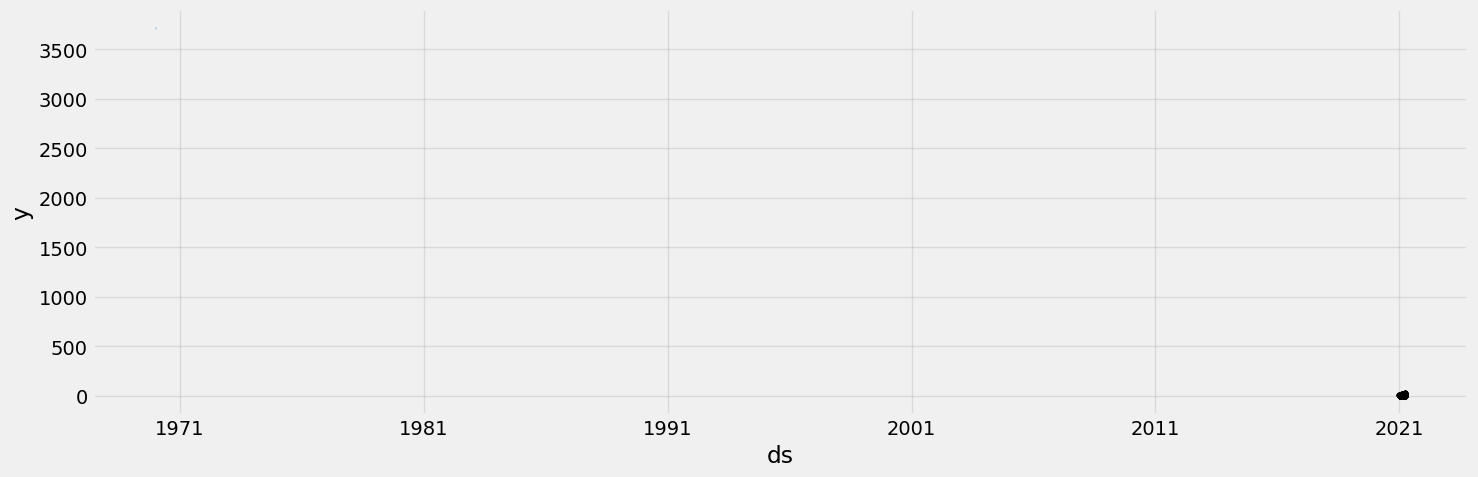

In [259]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(train_model,
                 ax=ax)
plt.show()

### COMPONENT OF FORECASTS
The components of the forecasts such as ‘trend’ , ‘seasonality’ , ‘Impact of additional regressor’ can be visualized. 

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



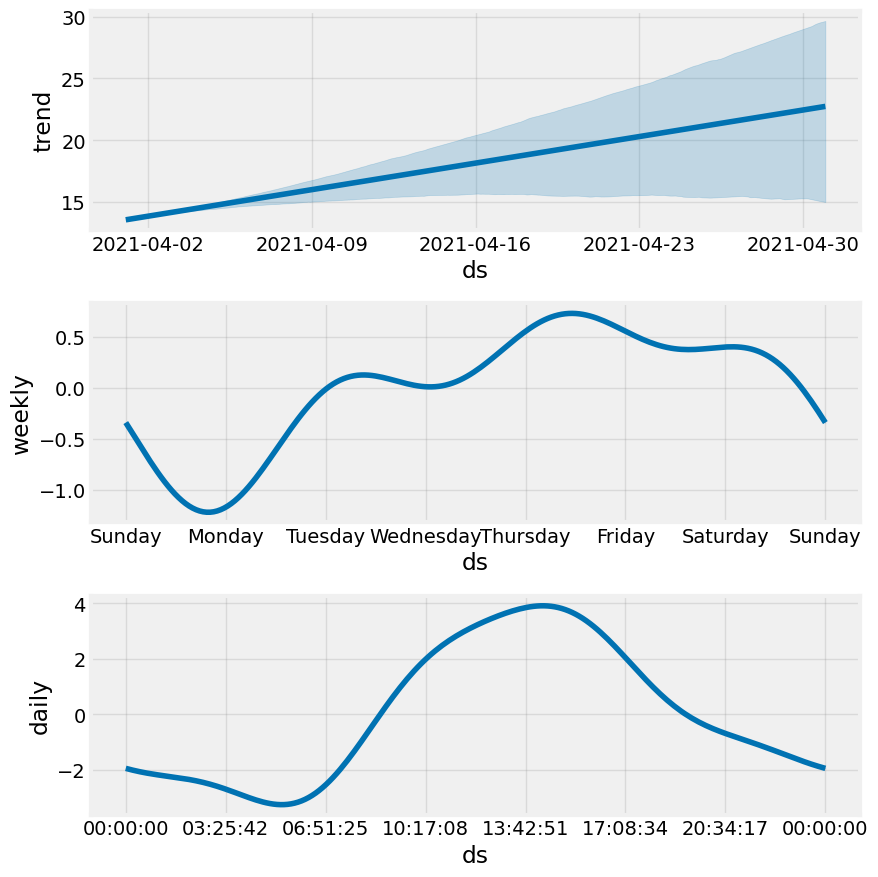

In [187]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)


The above plot shows the seasonality components captured by Prophet model. Seasonality such as ‘daily’ and ‘weekly’ are default components in Prophet.

Additionally, we also have custom seasonal components ‘quarterly’ and ‘yearly’.

Finally, we have built time series forecasting model using Facebook’s Prophet. Now, we shall move to evaluate the forecasted results.

### MODEL EVALUATION
Observed values ( Actuals ) and Predicted values should be merged with respect to date for model performance and evaluation. 
This helps us to know if there are any possible tuning can be done to get improvised better  results.

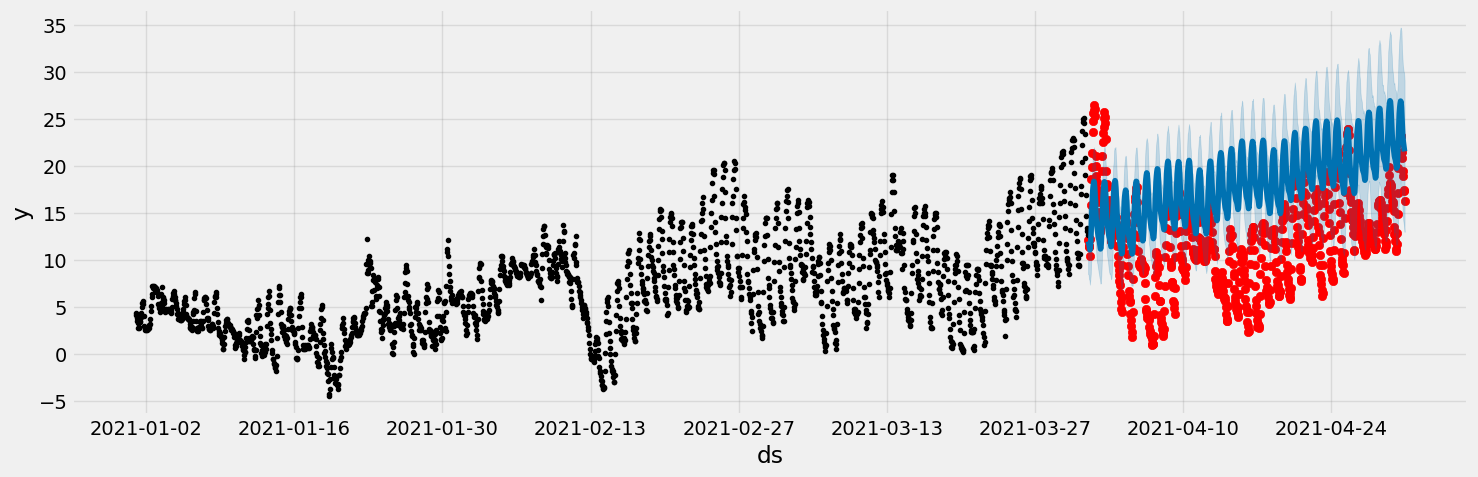

In [188]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['y'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

### Look at first month of predictions¶

KeyError: 'ds'

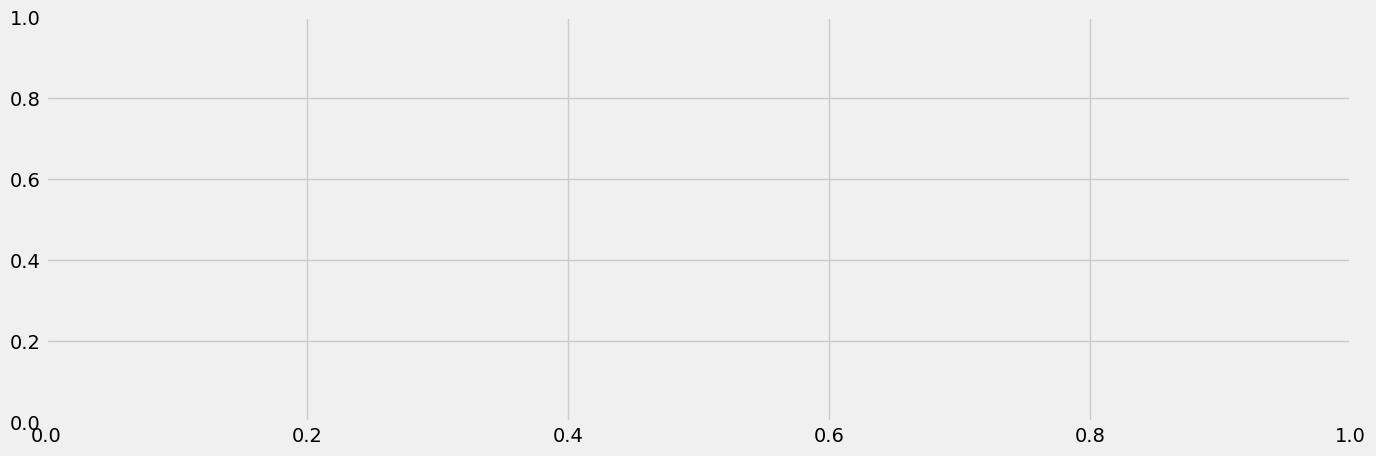

In [193]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['ds'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='2021-03-01',
              upper='2021-04-01')
ax.set_ylim(0, 60000)
plot = plt.suptitle('March 2021 Forecast vs Actuals')


### Single Week of Predictions

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')


### Error Metrics

In [192]:
mean_squared_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])